# Spred sheet processing

Parse a given CSV file and evaluate each cell by these rules:
1. Each cell is an expression in postfix notation. Please refer to the wikipedia page for a full description.
2. Each number or operation will always be separated by one or more spaces.
3. A cell can refer to another cell, via the LETTER NUMBER notation (A2, B4, etc - letters refer to columns, numbers to rows).
4. Support the basic arithmetic operators +, -, *, /

The output will be a CSV file of the same dimensions, where each cell is evaluated to its final value. If any cell is an invalid expression, then for that cell only print #ERR.

For example, the following CSV input:
```
10, 1 3 +, 2 3 -
b1 b2 *, a1, b1 a2 / c1 +
+, 1 2 3, c3
```

Might output something like this:
```
10,4,-1
40,10,-0.9
#ERR,#ERR,#ERR
```

## Approach

A spred sheet is a graph of cells which can consist of multiple sub graphs.



In [1]:
from typing import (
    List,
    Dict,
    Set,
    Tuple,
    Callable,
    Iterable,
    Any,
    Optional,
    Union,
)
import os
import sys
import logging
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import (
    product
)

In [2]:
%load_ext autoreload
%autoreload 2

from spredsheet import (
    load_table,
    parse_table_into_graph,
    process_table,
    save_result_table,
)
from networkx_utility import (
    draw_graph,
    list_reverse_topological_sorted_paths_in_graph,
)

<Figure size 432x288 with 0 Axes>

In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)

# Read table as dataframe

In [4]:
# df: pd.DataFrame = load_table("./data/sheet.csv")
df: pd.DataFrame = load_table("./data/example.csv")
df

,a,b,c
1,10,1 3 +,2 3 -
2,b1 b2 *,a1,b1 a2 / c1 +
3,+,1 2 3,c3
4,-1,a4 c4 *,c4 b3 *
5,+,c4,c5


In [5]:
COLUMN_NAMES = list(df.columns)
ROW_INDICES = list(df.index)
NUM_COLS = len(COLUMN_NAMES)
NUM_ROWS = len(df.index)

# Parse table as graph

In [6]:
sheet = parse_table_into_graph(table=df)
sheet.nodes(data=True)

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File

NodeDataView({'a1': {'valid': True, 'expression': '10', 'value': nan}, 'a2': {'valid': True, 'expression': 'b1 b2 *', 'value': nan}, 'b2': {'valid': True, 'expression': 'a1', 'value': nan}, 'b1': {'valid': True, 'expression': '1 3 +', 'value': nan}, 'a3': {'valid': True, 'expression': '+', 'value': nan}, 'a4': {'valid': True, 'expression': '-1', 'value': nan}, 'a5': {'valid': True, 'expression': '+', 'value': nan}, 'b3': {'valid': True, 'expression': '1 2 3', 'value': nan}, 'b4': {'valid': True, 'expression': 'a4 c4 *', 'value': nan}, 'c4': {'valid': False, 'expression': 'c4 b3 *', 'value': nan}, 'b5': {'valid': True, 'expression': 'c4', 'value': nan}, 'c1': {'valid': True, 'expression': '2 3 -', 'value': nan}, 'c2': {'valid': True, 'expression': 'b1 a2 / c1 +', 'value': nan}, 'c3': {'valid': False, 'expression': 'c3', 'value': nan}, 'c5': {'valid': False, 'expression': 'c5', 'value': nan}})

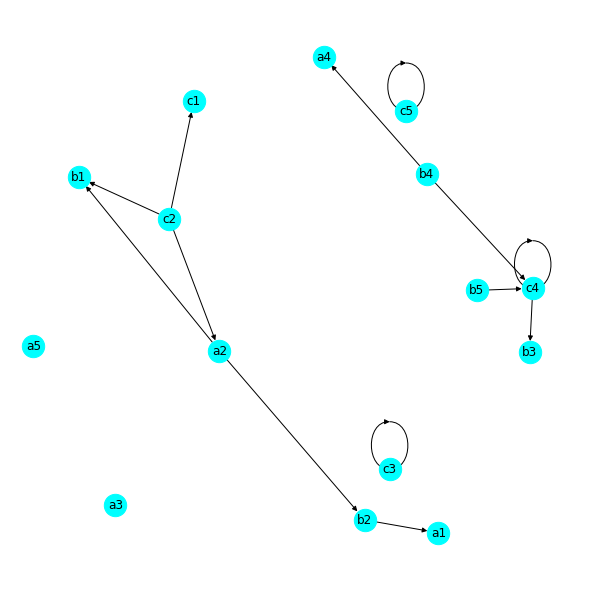

In [16]:
_ = draw_graph(graph=sheet, k=0.5, seed=10, figsize=(8,8))

---
# Individual path to process


## Toplogical Graph Sort
Each sub graph in the table can be independently processed but in the order where dependency is assured. For instance, if the cell **a1** depends on **b1** and **b1** depends on **c1**, then the the order needs to be ```c1 > b1 > a1```. Use graph topological sort to get the order for each sub graph.

## Parallel processing

Each sub graph can be processed in parallel.


In [8]:
list_reverse_topological_sorted_paths_in_graph(sheet)

[['a1', 'b1', 'b2', 'a2', 'c1', 'c2'], ['a3'], ['a4'], ['a5'], ['b3']]

---
# Processing

In [9]:
process_table(table=sheet)

ERROR:spredsheet:evaluate_expression(): operation requires two operands but stack size is [0]
ERROR:spredsheet:evaluate_expression(): operator result is invalid: [nan]
ERROR:spredsheet:evaluate_cell(): cell evaluation [nan] is invalid
ERROR:spredsheet:evaluate_expression(): operation requires two operands but stack size is [0]
ERROR:spredsheet:evaluate_expression(): operator result is invalid: [nan]
ERROR:spredsheet:evaluate_cell(): cell evaluation [nan] is invalid
ERROR:spredsheet:evaluate_expression(): evaluation of [1 2 3] failed with stack size [3].
ERROR:spredsheet:evaluate_cell(): cell evaluation [nan] is invalid


In [10]:
filename: str = "./data/result.csv"
save_result_table(
    table=sheet, column_names=COLUMN_NAMES, row_indices=ROW_INDICES, path_to_file=filename
)

In [11]:
10,4,-1
40,10,-0.9
#ERR,#ERR,#ERR


(40, 10, -0.9)

In [12]:
!cat $filename
!rm -f ./data/result.csv

a,b,c
10.0,4.0,-1.0
40.0,10.0,-0.9
#ERR,#ERR,#ERR
-1.0,#ERR,#ERR
#ERR,#ERR,#ERR
